# A Simple Q-Learning example
![tiny-maze](./assets/tiny-maze.jpg)

Images credit: https://huggingface.co/learn/deep-rl-course

### Environment:
- 6 cell grid, and the mouse always starts in the same spot (upper left)
- The goal is to eat the big pile of cheese at the bottom right-hand corner and avoid the poison
- Mouse can move left, right, up, down
- Can take a maximum of 5 steps per episode
- Episode ends if mouse eats poison or big cheese or after taking five steps

### Reward function:
- +10 for eating big pile of cheese
-  +1 for eating small cheese
- -10 for eating poison
-  +0 for going to a state with no cheese in it

In [1]:
import math

import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch import Tensor

# (x, y) actions
ACTIONS = torch.tensor(
    [
        [-1, 0],  # left
        [1, 0],  # right
        [0, -1],  # up
        [0, 1],  # down
    ]
)
NUM_ACTIONS = ACTIONS.shape[0]
REWARDS = torch.tensor([[0.0, 1.0, 0.0], [0.0, -10.0, 10.0]])
NUM_STATES = math.prod(REWARDS.shape)

print("2D reward map:")
print(REWARDS)

print("\nFlattened reward map:")
print(REWARDS.flatten()[:, None])

2D reward map:
tensor([[  0.,   1.,   0.],
        [  0., -10.,  10.]])

Flattened reward map:
tensor([[  0.],
        [  1.],
        [  0.],
        [  0.],
        [-10.],
        [ 10.]])


# Define state transitions

- Assume the 2x3 grid does not wrap around itself
    - i.e. if you are at left edge and you choose to move left, you stay at the same spot
- Assume the transition from one cell to the next is completely deterministic 
    - i.e. if you choose to move left (and are able), you go left 100% of the time
    - this is in contrast to a stochastic environment (e.g. a slippery grid) where the
    chosen action my not result in the intended effect 100% of the time

In [2]:
def init_state_transitions(grid_shape: tuple[int, int], actions: Tensor) -> Tensor:
    """Initialize deterministic state transition matrix for a 2D grid world.

    Parameters
    ----------
    grid_shape : tuple[int, int]
        The shape of the grid world.
    actions : Tensor[num_act, 2]
        The set of (dx, dy) actions available to agent at each state.

    Returns
    -------
    next_states : Tensor[num_states, num_act]
        The next state indices for each state-action pair.
    """
    h, w = grid_shape

    # Define 2D coordinates for each cell in the grid: (2, h, w)
    xy_coords = torch.stack(
        torch.meshgrid(torch.arange(w), torch.arange(h), indexing="xy"), dim=0
    )

    # Apply each action to each state to get coordinates of the next state
    # (num_act, 2, 1, 1) + (1, 2, h, w) -> (num_act, 2, h, w)
    next_xy_coords = actions[..., None, None] + xy_coords[None, ...]

    # Clip out-of-bounds coordinates
    lb = torch.tensor([0, 0]).view(1, 2, 1, 1)
    ub = torch.tensor([w - 1, h - 1]).view(1, 2, 1, 1)
    next_xy_coords = next_xy_coords.clamp(lb, ub)

    # Convert 2D coordinates to 1D state indices
    # (num_act, 2, h, w) -> (num_act, h, w)
    next_states = next_xy_coords[:, 1, ...] * w + next_xy_coords[:, 0, ...]

    # Flatten the state indices
    # (num_act, h, w) -> (num_act, num_states)
    next_states = next_states.view(actions.size(0), -1)

    # Transpose: (num_states, num_act)
    return next_states.T


next_states = init_state_transitions(REWARDS.shape, ACTIONS)

print("\nState transitions:")
print(next_states)


State transitions:
tensor([[0, 1, 0, 3],
        [0, 2, 1, 4],
        [1, 2, 2, 5],
        [3, 4, 0, 3],
        [3, 5, 1, 4],
        [4, 5, 2, 5]])


# Define update for Q-table

![update-formula](assets/q-table-update.png)

In [3]:
def update_q_table(
    q_table: Tensor,
    state_action: tuple[int, int],
    reward: float,
    next_state: int | None,
    gamma: float,
    learning_rate: float,
) -> Tensor:
    """Update Q-table (state, action) pair.

    Parameters
    ----------
    q_table: Tensor[num_states, num_act, dtype=float32]
        The Q-table to update.
    state_action: tuple[int, int]
        State-action pair to update.
    reward: float
        The reward | action.
    next_state: int | None
        The next state | action.
    gamma : float
        Future value discount factor.
    learning_rate : float
        Learning rate.

    Returns
    -------
    updated_q_table: Tensor[num_states, num_act, dtype=float32]
        The updated Q-table.
    """
    # Compute the maximum Q-value for next state
    max_q_value = 0.0
    if next_state is not None:
        max_q_value = q_table[next_state].max(dim=-1).values

    # Compute the temporal difference target
    td_target = reward + gamma * max_q_value

    # Compute update for state-action pair
    state, action = state_action
    q_table[state, action] = (
        q_table[state, action] * (1 - learning_rate) + learning_rate * td_target
    )

    return q_table

# 1. Initialize Q-table

In [4]:
def init_q_table(num_states: int, num_actions: int) -> Tensor:
    """Initialize the Q-table with zeros for all (state, action) pairs."""
    return torch.zeros(num_states, num_actions)


q_table = init_q_table(NUM_STATES, NUM_ACTIONS)
q_table

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

# 2. Define epsilon-greedy policy

In [5]:
def get_action(q_table: Tensor, state: int, epsilon: float) -> int:
    """Select an action using an epsilon-greedy strategy."""
    if torch.rand(()) < epsilon:
        # Choose a random action
        return torch.randint(q_table.shape[-1], ()).item()
    else:
        # Given the current state, choose the best action in the Q-table
        return q_table[state].argmax().item()

# 3. Learning

In [6]:
# Set hyperparameters
LR = 0.1  # learning rate
GAMMA = 0.99  # future reward discount rate

# Initialize epsilon (exploration vs exploitation tradeoff) to 1.0 (full exploration)
epsilon = 1.0

# Initialize state to upper left
state = 0

## Learn for one time step

1. Starting from the upper left square, choose an action using Epsilon greedy strategy
    - assume we sampled move right (`action=1`)
2. Perform action, get reward and next state

![state1](assets/tiny-maze-state1.png)

In [7]:
# Choose an action using the Epsilon Greedy Strategy
torch.manual_seed(6)
action = get_action(q_table, state, epsilon)
print(f"state: {state}, action: {action}")

# Perform action At, get Rt+1 and St+1
next_state = next_states[state, action].item()
reward = REWARDS.flatten()[next_state].item()
print(f"reward: {reward}, next_state: {next_state}")

state: 0, action: 1
reward: 1.0, next_state: 1


 3. Update `Q(St, At)`

 ![updated](assets/tiny-maze-update1.png)

In [8]:
# Update q-table
q_table = update_q_table(
    q_table, (state, action), reward, next_state, gamma=GAMMA, learning_rate=LR
)

print("\nUpdated Q-table:")
print(
    pd.DataFrame(
        data=q_table.numpy().round(2),
        columns=["left", "right", "up", "down"],
    )
)

# Set state to next state
state = next_state


Updated Q-table:
   left  right   up  down
0   0.0    0.1  0.0   0.0
1   0.0    0.0  0.0   0.0
2   0.0    0.0  0.0   0.0
3   0.0    0.0  0.0   0.0
4   0.0    0.0  0.0   0.0
5   0.0    0.0  0.0   0.0


## Learn for another time step

1. choose next action using Epsilon greedy strategy
    - assume we sampled move down (`action=3`)
2. Perform action, get reward and next state

![state1](assets/tiny-maze-state2.png)

In [9]:
state = next_state
# Choose an action using the Epsilon Greedy Strategy
torch.manual_seed(0)
action = get_action(q_table, state, epsilon)
print(f"state: {state}, action: {action}")

# Perform action At, get Rt+1 and St+1
next_state = next_states[state, action].item()
reward = REWARDS.flatten()[next_state].item()
print(f"reward: {reward}, next_state: {next_state}")

# Update q-table
q_table = update_q_table(
    q_table,
    (state, action),
    reward,
    None,  # episode terminated
    gamma=GAMMA,
    learning_rate=LR,
)

print("\nUpdated Q-table:")
print(
    pd.DataFrame(
        data=q_table.numpy().round(2),
        columns=["left", "right", "up", "down"],
    )
)

state: 1, action: 3
reward: -10.0, next_state: 4

Updated Q-table:
   left  right   up  down
0   0.0    0.1  0.0   0.0
1   0.0    0.0  0.0  -1.0
2   0.0    0.0  0.0   0.0
3   0.0    0.0  0.0   0.0
4   0.0    0.0  0.0   0.0
5   0.0    0.0  0.0   0.0


## Run for several episodes


Final Q-table:
   left  right    up   down
0  9.86  10.80  9.62   7.92
1  9.81   9.90  7.48  -9.94
2  7.39   9.22  9.06  10.00
3  2.61  -7.71  9.37   3.25
4  0.00   0.00  0.00   0.00
5  0.00   0.00  0.00   0.00


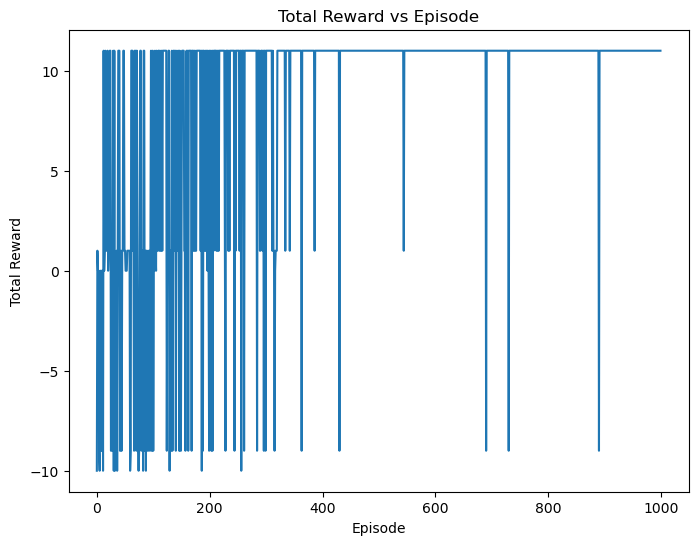

In [10]:
torch.manual_seed(1234)
EPSILON_DECAY = 0.995

# Re-initialize Q-table
q_table = init_q_table(NUM_STATES, NUM_ACTIONS)
epsilon = 1.0

total_rewards = []
for _ in range(1_000):
    total_reward = 0.0
    num_steps = 0
    state = 0
    small_cheese_available = True

    while num_steps < 5:
        num_steps += 1

        # Choose an action using the Epsilon Greedy Strategy
        action = get_action(q_table, state, epsilon)

        # Perform action At, get Rt+1 and St+1
        next_state = next_states[state, action].item()
        reward = REWARDS.flatten()[next_state].item()

        # Check if small cheese is available
        if reward == 1.0:
            if small_cheese_available:
                small_cheese_available = False
            else:
                reward = 0.0

        # Update total reward
        total_reward += reward

        # Check if terminal condition
        if int(reward) in (-10, 10) or num_steps == 5:
            next_state = None

        # Update q-table
        q_table = update_q_table(
            q_table, (state, action), reward, next_state, gamma=GAMMA, learning_rate=LR
        )

        if next_state is None:
            break

        # Set state to next state
        state = next_state

    total_rewards.append(total_reward)

    # Decay epsilon
    epsilon *= EPSILON_DECAY

print("\nFinal Q-table:")
print(
    pd.DataFrame(
        data=q_table.numpy().round(2),
        columns=["left", "right", "up", "down"],
    )
)

_, ax = plt.subplots(figsize=(8, 6))
ax.plot(total_rewards)
ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")
ax.set_title("Total Reward vs Episode");